In [6]:
import os
import matplotlib.gridspec as gridspec
import matplotlib.image as img
import matplotlib.pyplot as plt

import numpy as np
import cv2

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label
from skimage.feature import hog

from moviepy.editor import VideoFileClip

from Features import FeaturesExtractor
from Dataset import DataProvider
from LaneLines import Line

class Windows():
    def __init__(self):
        self.fte =FeaturesExtractor()
    
    
    def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None],\
                             xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] is None:
            x_start_stop[0] = 0
        if x_start_stop[1] is None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] is None:
            y_start_stop[0] = 0
        if y_start_stop[1] is None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan / nx_pix_per_step) - 1
        ny_windows = np.int(yspan / ny_pix_per_step) - 1
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs * nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys * ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    def search_windows(self, img, windows, clf, scaler, color_space,
                   spatial_size, hist_bins,
                   orient, pix_per_cell, cell_per_block,
                   hog_channel, spatial_feat,
                   hist_feat, hog_feat):
    
        on_windows = []
        for window in windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            extracted_features = self.fte.extract_features([test_img], cspace=color_space, orient=orient, spatial_size=spatial_size,
                                                  hist_bins=hist_bins,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                  spatial_feat=spatial_feat, hist_feat=hog_feat, hog_feat=hist_feat,
                                                  hog_channel=hog_channel)

            test_features = scaler.transform(np.array(extracted_features).reshape(1, -1))
            prediction = clf.predict(test_features)

            if prediction == 1:
                on_windows.append(window)
        return on_windows
    
    # Define a function to draw bounding boxes
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy
    
    def add_heat(self,heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap


    def draw_sliding_windows(self,image, windows, color=(197, 27, 138), thick=3):
       
        for window in windows:
            cv2.rectangle(image, window[0], window[1], color, thick)
        return image

    def apply_threshold(self,heatmap, threshold):
       
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap


    def draw_labeled_bboxes(self, img, labels):
       
        # Iterate through all detected cars
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (197, 27, 138), 3)
        # Return the image
        return img

class FrameQueue:
    def __init__(self, max_frames):
        self.frames = []
        self.max_frames = max_frames

    def enqueue(self, frame):
        self.frames.insert(0, frame)

    def _size(self):
        return len(self.frames)

    def _dequeue(self):
        num_element_before = len(self.frames)
        self.frames.pop()
        num_element_after = len(self.frames)

        assert num_element_before == (num_element_after + 1)

    def sum_frames(self):
        if self._size() > self.max_frames:
            self._dequeue()
        all_frames = np.array(self.frames)
        return np.sum(all_frames, axis=0)
    
    
class Vehicle:
    def __init__(self, color_space, orient, pix_per_cell, cell_per_block,
                 hog_channel, spatial_size, hist_bins, spatial_feat,
                 hist_feat, hog_feat, y_start_stop, x_start_stop, xy_window,
                 xy_overlap, heat_threshold, scaler, classifier):
        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.y_start_stop = y_start_stop
        self.x_start_stop = x_start_stop
        self.xy_window = xy_window
        self.xy_overlap = xy_overlap
        self.heat_threshold = heat_threshold
        self.scaler = scaler
        self.classifier = classifier
        self.win = Windows()
        self.frame_queue = FrameQueue(25)

    def detect(self, input_image):
        copy_image = np.copy(input_image)
        copy_image = copy_image.astype(np.float32) / 255

        slided_windows = self.win.slide_window(copy_image, x_start_stop=self.x_start_stop,
                                      y_start_stop=self.y_start_stop,
                                      xy_window=self.xy_window, xy_overlap=self.xy_overlap)

        on_windows = self.win.search_windows(copy_image, slided_windows, self.classifier, self.scaler,
                                    color_space=self.color_space, spatial_size=self.spatial_size,
                                    hist_bins=self.hist_bins, orient=self.orient,
                                    pix_per_cell=self.pix_per_cell, cell_per_block=self.cell_per_block,
                                    hog_channel=self.hog_channel, spatial_feat=self.spatial_feat,
                                    hist_feat=self.hist_feat, hog_feat=self.hog_feat)

        heat_map = np.zeros_like(copy_image)
        heat_map = self.win.add_heat(heat_map, on_windows)
        self.frame_queue.enqueue(heat_map)

        all_frames = self.frame_queue.sum_frames()
        heat_map = self.win.apply_threshold(all_frames, self.heat_threshold)

        labels = label(heat_map)

        image_with_bb = self.win.draw_labeled_bboxes(input_image, labels)
        return image_with_bb
    
    @staticmethod
    def run(video=True):
        veh_fnames = DataProvider.files('./vehicles')
        nveh_fnames = DataProvider.files('./non-vehicles')
        vehimages = [img.imread(f) for f in veh_fnames]
        nvehimages = [img.imread(f) for f in nveh_fnames]
        # Define HOG parameters
        orient = 11 # 9
        pix_per_cell = 16 # 8
        cell_per_block = 2
        # Call our function with vis=True to see an image output
        fte = FeaturesExtractor()
        color_space = 'YUV' #'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
        spatial_size = (32, 32)  # Spatial binning dimensions
        hist_bins = 32  # Number of histogram bins
        spatial_feat = True  # Spatial features on or off
        hist_feat = True  # Histogram features on or off
        hog_feat = True  # HOG features on or off
        x_start_stop=[None, None]
        y_start_stop = [400,600]
        xy_window=(96, 85)
        xy_overlap=(0.75, 0.75)

        C_values = [0.08, 0.2, 0.4, 0.8, 1.0, 1.2, 1.4, 1.8, 2.6]
        penalties = ['l2']
        losses = ['hinge', 'squared_hinge']

        training_accuracies = []
        validation_accuracies = []
        best_c = 1.0
        best_penalty = 'l2'
        best_loss = 'hinge'

        best_accuracy = 0.0

        vfeatures = fte.extract_features(vehimages, color_space, orient, spatial_size, hist_bins,\
                                                    pix_per_cell, cell_per_block, spatial_feat, hist_feat, hog_feat,\
                                                    hog_channel)
        
        print('vehicle features dimensions: {}'.format(vfeatures.shape))

        nvfeatures = fte.extract_features(nvehimages, color_space, orient, spatial_size,\
                                                        hist_bins, pix_per_cell, cell_per_block, spatial_feat,\
                                                        hist_feat, hog_feat, hog_channel)
        
        print('non-vehicle features dimensions: {}'.format(nvfeatures.shape))

        X_features = np.vstack((vfeatures, nvfeatures)).astype(np.float64)
        print('Dataset dimensions: {}'.format(vfeatures.shape))

        y_features = np.hstack((np.ones(len(vehimages)), np.zeros(len(nvehimages))))
        
        for c in C_values:
            for penalty in penalties:
                for loss in losses:
                    X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                                                        test_size=0.3, random_state=2048)

                    scaler = StandardScaler().fit(X_train)

                    X_train = scaler.transform(X_train)
                    X_test = scaler.transform(X_test)

                    svc = LinearSVC(C=c, penalty=penalty, loss=loss).fit(X_train, y_train)
                    accuracy = svc.score(X_test, y_test)
                    print('Validation accuracy: {:.4f} with C: {}, panelty: {}, loss: {}'.format(
                        accuracy, c, penalty, loss))

                    if best_accuracy < accuracy:
                        best_accuracy = accuracy
                        best_c = c
                        best_loss = loss
                        best_penalty = penalty

                    validation_accuracies.append(accuracy)
                    training_accuracies.append(svc.score(X_train, y_train))

        print('Best validation accuracy: {:.4f}'.format(best_accuracy))
        print('Best parameters: C: {}, penalty: {}, loss: {}'.format(best_c, best_penalty, best_loss))

        print('')
        print('Best hyper-parameters')
        
        scaler = StandardScaler().fit(X_features)
        X_features = scaler.transform(X_features)
        svc = LinearSVC(C=best_c, penalty=best_penalty, loss=best_loss).fit(X_features, y_features)

        vehicle = Vehicle(color_space=color_space,
                                          orient=orient,
                                          pix_per_cell=pix_per_cell,
                                          cell_per_block=cell_per_block,
                                          hog_channel=hog_channel,
                                          spatial_size=spatial_size,
                                          hist_bins=hist_bins,
                                          spatial_feat=spatial_feat,
                                          hist_feat=hist_feat,
                                          hog_feat=hog_feat,
                                          y_start_stop=y_start_stop,
                                          x_start_stop=x_start_stop,
                                          xy_window=xy_window,
                                          xy_overlap=xy_overlap,
                                          heat_threshold = 15,
                                          scaler=scaler,
                                          classifier=svc)
        line = Line()
            
        if video :
            output_file = './processed_project_video.mp4'
            input_file = './project_video.mp4'
            clip = VideoFileClip(input_file)
            out_clip = clip.fl_image(vehicle.detect)
            out_clip.write_videofile(output_file, audio=False)
            clip = VideoFileClip(output_file)
            out_clip = clip.fl_image(line.run())
            out_clip.write_videofile('./processed_project_video_2.mp4', audio=False)
        else:
            imgs = ['test1.jpg','test2.jpg','test3.jpg','test4.jpg',\
                    'test5.jpg','test6.jpg']
            for fname in imgs:
                imag = cv2.imread('./test_images/'+fname)
                imag = vehicle.detect(imag)
                cv2.imwrite('./output_images/'+fname,imag)
       
        




In [5]:
#Vehicle.run(video=True)

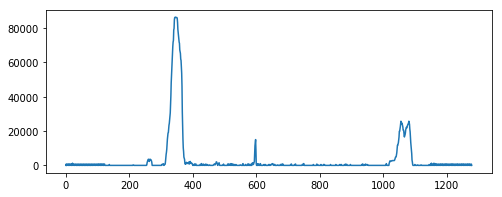

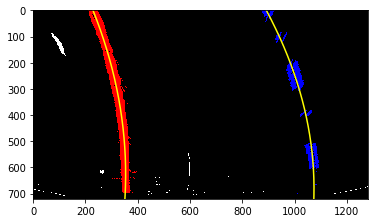

[MoviePy] >>>> Building video ./processed_project_video_2.mp4
[MoviePy] Writing video ./processed_project_video_2.mp4


100%|█████████▉| 1260/1261 [04:22<00:00,  4.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video_2.mp4 



In [11]:
line = Line()
output_file = './processed_project_video.mp4'
clip = VideoFileClip(output_file)
out_clip = clip.fl_image(line.run)
out_clip.write_videofile('./processed_project_video_2.mp4', audio=False)